# Creating the polluted data

In [18]:
import yaml
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from fault_management_uds.config import Config
from fault_management_uds.data.load import import_metadata
from fault_management_uds.data.hdf_tools import delete_group, create_group, print_tree, save_dataframe_in_HDF5, load_dataframe_from_HDF5, update_filtered_data_in_HDF5
from fault_management_uds.data.process import remove_nans_from_start_end
from fault_management_uds.data.dataset import handle_splits, identify_valid_indices


from fault_management_uds.synthetic.synthetic_generator import AnomalyHandler, find_unterrupted_sequences


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta

## Prepare

In [21]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

f = print_tree(data_file_path, 'combined_data')

# # create a new group called anomalous
# create_group(data_file_path, 'combined_data/anomalous', verbose=False)
# f = print_tree(data_file_path, 'combined_data')
delete_group(data_file_path, 'combined_data/anomalous', verbose=False)

combined_data
├── clean
│   ├── columns
│   ├── data
│   └── timestamps
└── raw
    ├── columns
    ├── data
    └── timestamps


In [22]:
# load yaml file
with open(REFERENCE_DIR / 'synthetic_config.yaml', 'r') as f:
    synthetic_config = yaml.safe_load(f)

metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
# load the sensor ranges
with open(REFERENCE_DIR / 'sensor_ranges.json', 'r') as f:
    sensor_ranges = json.load(f)

## Define synthetic data

In [23]:
# select a experiment configuration as base
experiment_config_path = 'transformer/6_final_selection/final.yaml'

# create the config
config = Config(experiment_config_path, fast_run=False, save_folder=None, num_workers=0)

In [24]:
# the sensor to pollute
sensor_name = config.config['dataset_args']['endogenous_vars'][0]
print(f"Sensor to pollute: {sensor_name}")

# the variables to save
data_variables = config.config['dataset_args']['data_variables']
print(f"Data variables: {data_variables}")

Sensor to pollute: G71F04R_Level2
Data variables: ['5425', 'G71F05R_LevelInlet', 'G71F06R_LevelInlet', 'G71F04R_Level2']


In [25]:
# Extract more info
sensor_scale = sensor_ranges[sensor_name]['clean']['range']
sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
unit = sensor_meta['UnitAlias'].values[0]
obvious_min = sensor_meta['obvious_min'].values[0]
obvious_max = sensor_meta['obvious_max'].values[0]  

#### Load data

In [26]:
# load data
data, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'combined_data/clean')
# filter the data based on the sensor name (remove nan from start and end)
data = remove_nans_from_start_end(data, sensor_name)
# filter out the necessary data variables
data = data[data_variables]

#### Prepare for anomaly injection

In [27]:
anomalies = list(synthetic_config['anomalies'].keys())
print(anomalies)    
severity = "medium"
# buffers should be the separated by at least the sequence length
buffer = config.config['dataset_args']['sequence_length']
# edge buffer should be the separated by at least the prediction ahead and the sequence length
edge_buffer = config.config['dataset_args']['sequence_length'] + config.config['predict_steps_ahead']


['spike', 'noise', 'frozen', 'offset', 'drift']


In [28]:
not_nan_mask = np.logical_not(np.isnan(data.values).any(axis=1))
valid_indices = identify_valid_indices(not_nan_mask, 
                                       config.config['dataset_args']['sequence_length'], 
                                       config.config['predict_steps_ahead'])

## Inject the anomalies

In [29]:
# convert form tensor to list
valid_indices = list(valid_indices)
n_obs = len(data)
indicators = np.zeros(n_obs)
polluted_data = data.copy()

indicator_2_data_label = {
    0: 'Original',
}
    
for i, anomaly in enumerate(anomalies):
    print(f"Anomaly: {anomaly}")
    anomaly_config = synthetic_config['anomalies'][anomaly][severity]


    anomaly_handler = AnomalyHandler(anomaly_config, anomaly, config.config['dataset_args']['endogenous_vars'], n_obs, sensor_scale, obvious_min, obvious_max, 
                                     seed=config.config['training_args']['seed'],
                                     buffer=buffer, edge_buffer=edge_buffer, available_indices=valid_indices)

    # Inject anomalies
    anomaly_handler.initialize_injections()
    # on the polluted
    polluted_data = anomaly_handler.inject_anomalies(polluted_data)
    # get the indicator
    polluted_indicator = anomaly_handler.get_indicator()
    # set 1 (anomaly) values to i+1
    #anomaly_2_indicator[anomaly] = i+1
    indicator_2_data_label[i+1] = anomaly.capitalize()
    polluted_indicator = polluted_indicator * (i+1)
    # join the indicators; but keep the polluted indicator value
    indicators = np.maximum(indicators, polluted_indicator) # keep the highest value

    # Only keep indices that are not polluted
    valid_indices = [i for i in valid_indices if not indicators[i]] # remove the polluted indices if not 0
    print('')

# remap the indicators to the original values
#indicators = np.array([indicator_2_data[i] for i in indicators])

Anomaly: spike
Total injections: 1250
Edge buffer is in available indices.
Last index is in available indices.

Anomaly: noise
Total injections: 259
Edge buffer is in available indices.

Anomaly: frozen
Total injections: 108
Edge buffer is in available indices.

Anomaly: offset
Total injections: 163
Edge buffer is in available indices.

Anomaly: drift
Total injections: 162
Edge buffer is in available indices.



In [32]:
print(f"Pollution proportion: {100*np.sum(indicators!=0)/n_obs:.2f}%")

Pollution proportion: 5.24%


## Save

In [33]:
# insert the indicators
polluted_data['Data Label'] = indicators

In [34]:
# save the dataframe in the HDF5
save_dataframe_in_HDF5(data_file_path, 'combined_data', 'anomalous', polluted_data)

# save the indicator_2_data_label as json
with open(REFERENCE_DIR / 'indicator_2_data_label.json', 'w') as f:
    json.dump(indicator_2_data_label, f)

In [35]:
# the result
f = print_tree(data_file_path, 'combined_data')

combined_data
├── anomalous
│   ├── columns
│   ├── data
│   └── timestamps
├── clean
│   ├── columns
│   ├── data
│   └── timestamps
└── raw
    ├── columns
    ├── data
    └── timestamps


## Split distribution

In [15]:
# get splits
splits = handle_splits(n_obs, config.config['dataset_args'])

# counts
occurrences = {}
total_duration = {}
for data_type, indices in zip(['Train', 'Val', 'Test'], splits[0]):
    occurrences[data_type] = {}
    total_duration[data_type] = {}
    labels = polluted_data.iloc[indices]['Data Label'].values
    for i, ano in indicator_2_data_label.items():
        # ignore the original
        if i == 0:
            continue
        
        # count total occurrences, by counting the number of times the label changes to i
        occurrences[data_type][ano] = sum(np.diff(labels == i) == 1)

        # count the total duration
        total_duration[data_type][ano] = sum(labels == i)

# turn each into a long dataframe
df_occurrences = pd.DataFrame(occurrences)

df_total_duration = pd.DataFrame(total_duration)

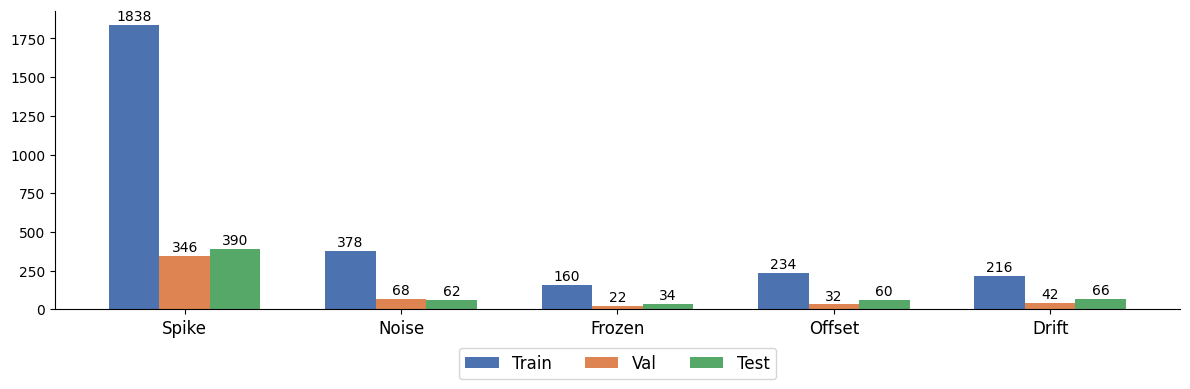

In [16]:
# visualize
# define figure
fig, ax = plt.subplots(figsize=(12, 4))
colors = sns.color_palette("deep")  # A Seaborn palette
train_color, val_color, test_color = colors[0], colors[1], colors[2]
ax = df_occurrences.plot(
    kind='bar', 
    stacked=False, 
    #figsize=(12, 4), 
    color=[train_color, val_color, test_color],
    ax=ax,
    width=0.7
    )

# Add text labels above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=1)
# legend at bottom, and increase size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize='large')
# remove grid lines
fig.gca().spines['top'].set_visible(False);fig.gca().spines['right'].set_visible(False)
# rotate the x labels
plt.xticks(rotation=0)
# increase x label size
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

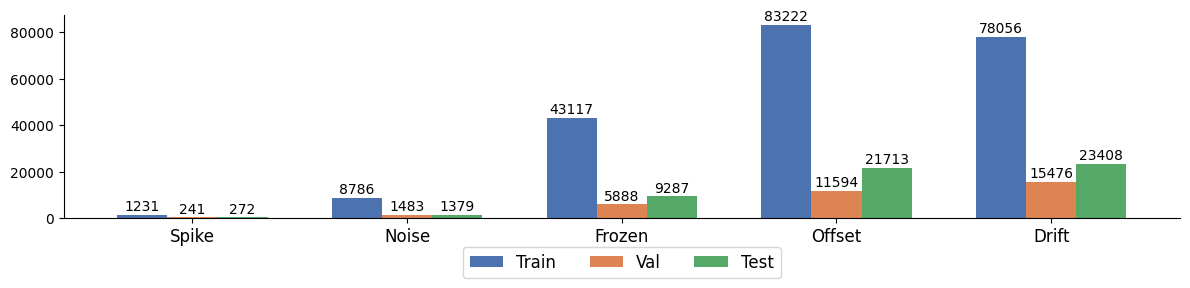

In [17]:
# visualize
# define figure
fig, ax = plt.subplots(figsize=(12, 3))
colors = sns.color_palette("deep")  # A Seaborn palette
train_color, val_color, test_color = colors[0], colors[1], colors[2]
ax = df_total_duration.plot(
    kind='bar', 
    stacked=False, 
    #figsize=(12, 4), 
    color=[train_color, val_color, test_color],
    ax=ax,
    # decrease space between bars
    width=0.7
    )

# Add text labels above bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=1)
# legend at bottom, and increase size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize='large')
# remove grid lines
fig.gca().spines['top'].set_visible(False);fig.gca().spines['right'].set_visible(False)
# rotate the x labels
plt.xticks(rotation=0)
# increase x label size
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# TODO: also pollution %